This code produces map plots of mean precipitation for each ITCZ state for all observations (IMERG (MW+IR), IMERG (MW), GPCP) and all CMIP6 models median (top, intermediate, and bottom groups) for January through May. The percent contribution of each ITCZ state's rainfall to mean rainfall is also computed.

In [1]:
#Author: Alex Gonzalez
#Date: November 2025
#Paper: JGR-Atmospheres

Figure 10. The same as Figure 5 but for IMERG combined microwave and IR observations
(MW+IR, 1998–2024) and the model median of three CMIP6 groups (1980–2014): top models
(n=2), intermediate models (n=12), and bottom models (n=11).

Table 2. Percent contribution (%) of each ITCZ state to the total precipitation over the east
Pacific Ocean (90◦W–135◦W, 20◦S–20◦N) in observations (IMERG (MW+IR), IMERG (MW), and
GPCP), reanalyses (ERA5, MERRA-2, CFSR, and JRA-3Q), and CMIP6 models (top, intermediate,
and bottom model groups) for January through May. Note that “All ITCZ” refers to all ITCZ
states except aITCZ.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
region = 'EastPac'#'Atlantic'# 'EastPac'
region_str = 'East Pacific Ocean'#'Atlantic Ocean'
rain_thresh_str = '5.0mm'

# months of interest
mn0 = 1
mnf = 5
mn_str = 'Jan-May'#'Jan-May'#Feb-Apr'

# year(s) of interest
yr0 = 1998
yrf = 2024
yr_str = str(yr0)+'-'+str(yrf)

figfolder = '/home/alex.gonzalez//CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
figname = 'CMIP6_Obs_pr_maps_'+region+'_'+mn_str+'_'+str(yr0)+'-'+str(yrf)+'_wide.pdf'

In [4]:
# wide latitudes
lat0 = -20.
lat1 = 20.

# longitudes – East Pac
lon0 = -170
lon1 = -70

# East Pacific box
lon0_box = -135
lon1_box = -90

# longitudes – Atlantic
#lonw = -70
#lone = 30
#lonw = -40
#lone = 5

In [5]:
itcz_states = ['dITCZ','nITCZ','sITCZ','aITCZ','eITCZ']
nitst = len(itcz_states)

In [6]:
def compute_itczst_maps(dri,fn_pr,fn_it,pr_name,tim_name,lat_name,lon_name,mn0,mnf,yr0,yrf):
    data = xr.open_dataset(dri+fn_pr)
    # set up conditional statements 
    cond1 = (data['time']['time.month'] >= mn0) & (data['time']['time.month'] <= mnf) # season of interest
    cond2 = (data['time']['time.year'] <= yrf) & (data['time']['time.year'] >= yr0) # season of interest
    # now find only the times of season
    time = data['time'].where((cond1) & (cond2), drop=True) 
    pr_orig = data[pr_name].sel({tim_name:time,lat_name:slice(lat0,lat1),lon_name:slice(lon0,lon1)})
    
    data = xr.open_dataset(dri+fn_it)
    # set up conditional statements 
    cond1 = (data['time']['time.month'] >= mn0) & (data['time']['time.month'] <= mnf) # season of interest
    cond2 = (data['time']['time.year'] <= yrf) & (data['time']['time.year'] >= yr0) # season of interest
    # now find only the times of season
    itcz_state = data['itcz_state'].where((cond1) & (cond2), drop=True) 
    
    time = pr_orig[tim_name] 
    lat = pr_orig[lat_name] 
    lon = pr_orig[lon_name] 
    nt = len(time)
    nlat = len(lat)
    nlon = len(lon)
    
    # initialize xarray for prc_ITCZ, pr_ITCZ
    pr_ITCZ = xr.DataArray(np.zeros((nlat,nlon,nitst)),coords=[lat,lon,itcz_states], \
                                    dims=[lat_name,lon_name,'itcz_state'])
    prc_ITCZ = np.zeros((nitst))
    for cc in range(0,nitst,1):
        cond_ITCZ = (itcz_state == cc+1)
        prc_ITCZ[cc] = round(len(itcz_state.where((cond_ITCZ), drop=True))/(len(itcz_state))*100,1)
        print(str(itcz_states[cc])+' happens '+str(prc_ITCZ[cc])+'% of the time.')
        if prc_ITCZ[cc] == 0:
            pr_ITCZ[:,:,cc] = pr_orig.mean(dim=(tim_name))*0
        else:
            pr_ITCZ[:,:,cc] = pr_orig.where((cond_ITCZ), drop=True).mean(dim=(tim_name))

    print('-------------------------------')
    return pr_ITCZ, prc_ITCZ

In [7]:
fld = '/srv/lss/IMERG_1deg/total_precip/'
fn_pr  = 'imerg_1deg_1998-2024_daily.nc'
fn_it = 'IMERG_ITCZ_st_daily_'+region+'_abs_thresh_'+rain_thresh_str+'.nc'
pr_name = 'precipitation'

yr0 = 1998
yrf = 2024

In [9]:
data = xr.open_dataset(fld+fn_pr)
coords_obs = list(data.coords)
tim_name = coords_obs[0]
lon_name_obs = coords_obs[1]
lat_name_obs = coords_obs[2]
coords_obs

['time', 'lon', 'lat']

In [10]:
[pr_ITCZ_obs, prc_ITCZ_obs] = compute_itczst_maps(fld,fn_pr,fn_it,pr_name,\
                                tim_name,lat_name_obs,lon_name_obs,mn0,mnf,yr0,yrf)

dITCZ happens 4.9% of the time.
nITCZ happens 64.8% of the time.
sITCZ happens 5.1% of the time.
aITCZ happens 22.0% of the time.
eITCZ happens 3.2% of the time.
-------------------------------


In [11]:
pr_ITCZ_obs

<xarray.DataArray (lat: 41, lon: 101, itcz_state: 5)>
array([[[6.74541140e+00, 7.09165001e+00, 9.29987526e+00, 6.46915197e+00,
         4.34377956e+00],
        [8.72745228e+00, 6.82272100e+00, 6.45949745e+00, 5.65492439e+00,
         5.40687990e+00],
        [7.27049446e+00, 6.77297640e+00, 6.37505770e+00, 6.24969053e+00,
         2.63138580e+00],
        ...,
        [8.85175988e-02, 2.99952812e-02, 8.67678672e-02, 3.63388807e-02,
         7.05038682e-02],
        [4.45351712e-02, 3.31075229e-02, 6.64285645e-02, 4.40472215e-02,
         8.68216902e-03],
        [3.70100476e-02, 1.47341385e-01, 1.04375012e-01, 1.20601386e-01,
         3.45833302e-02]],

       [[1.00574703e+01, 7.92785549e+00, 1.06083794e+01, 7.55091047e+00,
         4.77706432e+00],
        [7.80363560e+00, 6.90404654e+00, 8.42671299e+00, 6.21356106e+00,
         3.26904178e+00],
        [5.73371029e+00, 6.92123747e+00, 7.27604151e+00, 6.74201345e+00,
         2.94148254e+00],
...
        [3.73130584e+00, 3.49465728e+00, 2.45569611e+00, 2.37787580e+00,
         4.31064892e+00],
        [3.57096100e+00, 3.00330734e+00, 3.07107162e+00, 2.54933453e+00,
         3.16386580e+00],
        [2.65052104e+00, 3.19148993e+00, 2.34395218e+00, 2.31332088e+00,
         3.07811022e+00]],

       [[9.87675667e-01, 1.15044057e+00, 1.62886298e+00, 1.93557560e+00,
         9.27102804e-01],
        [1.18584168e+00, 1.27908432e+00, 1.75622642e+00, 1.57567024e+00,
         6.86395288e-01],
        [1.22993064e+00, 1.39685583e+00, 2.43009520e+00, 1.41444349e+00,
         4.94534850e-01],
        ...,
        [1.28740609e+00, 1.77953231e+00, 2.00918484e+00, 1.59888113e+00,
         2.86372089e+00],
        [3.01378775e+00, 2.60699058e+00, 1.99321961e+00, 2.26297975e+00,
         4.57703543e+00],
        [3.21357918e+00, 2.77107048e+00, 3.03799915e+00, 2.35026169e+00,
         4.63050318e+00]]])
Coordinates:
  * lat         (lat) float64 -20.0 -19.0 -18.0 -17.0 ... 17.0 18.0 19.0 20.0
  * lon         (lon) float64 -170.0 -169.0 -168.0 -167.0 ... -72.0 -71.0 -70.0
  * itcz_state  (itcz_state) <U5 'dITCZ' 'nITCZ' 'sITCZ' 'aITCZ' 'eITCZ'

In [12]:
# now loop over good models
yr0 = 1980
yrf = 2014

In [13]:
models_g1 = ['CESM2-WACCM','NorESM2-MM']
#models_g1 = ['CESM2-WACCM','NorESM2-MM']
nmod_g1 = len(models_g1)

In [14]:
models_g2 = ['CESM2', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'E3SM-2-0', 'E3SM-2-0-NARRM',
       'FGOALS-f3-L', 'GFDL-CM4', 'HadGEM3-GC31-MM', 'MPI-ESM1-2-HR',
       'MRI-ESM2-0', 'SAM0-UNICON', 'TaiESM1']
#models_g2 = ['BCC-CSM2-MR','CAMS-CSM1-0','CNRM-CM6-1-HR','E3SM-2-0', \
#             'FGOALS-f3-L','HadGEM3-GC31-MM','MPI-ESM1-2-HR']
nmod_g2 = len(models_g2)

In [15]:
models_g3 = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CMCC-CM2-HR4', 'CNRM-CM6-1-HR',
       'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'GFDL-ESM4']
#models_g3 = ['CMCC-CM2-HR4','E3SM-1-0','EC-Earth3',
#             'GFDL-ESM4','MRI-ESM2-0','SAM0-UNICON','TaiESM1']
nmod_g3 = len(models_g3)

In [16]:
for gg in range(0,1,1):
    fld = '/srv/lss/CMIP6_precip_1deg/'+models_g1[gg]+'/'
    fn_pr = 'pr_'+models_g1[gg]+'_1980-2014_1deg_180.nc'
    fn_it = models_g1[gg]+'_ITCZ_st_daily_'+region+'_abs_thresh.nc'
    pr_name = 'pr'

    data = xr.open_dataset(fld+fn_pr)
    coords = list(data.coords)
    time_name = coords[0]
    lon_name = coords[1]
    lat_name = coords[2]

    lat_mod = data[lat_name].sel({lat_name:slice(lat0,lat1)})
    lon_mod = data[lon_name].sel({lon_name:slice(lon0,lon1)})

    ntim_mod = len(data[time_name])
    nlat_mod = len(lat_mod)
    nlon_mod = len(lon_mod)

In [17]:
pr_ITCZ_g1 = xr.DataArray(np.zeros((nlat_mod,nlon_mod,nitst,nmod_g1)),\
                          coords=[lat_mod,lon_mod,itcz_states,models_g1],\
                          dims=[lat_name,lon_name,'itcz_state','models'])
prc_ITCZ_g1 = xr.DataArray(np.zeros((nitst,nmod_g1)),coords=[itcz_states,models_g1],dims=['itcz_state','models'])

In [18]:
for gg in range(0,nmod_g1,1):
    fld = '/srv/lss/CMIP6_precip_1deg/'+models_g1[gg]+'/'
    fn_pr = 'pr_'+models_g1[gg]+'_1980-2014_1deg_180.nc'
    fn_it = models_g1[gg]+'_ITCZ_st_daily_'+region+'_abs_thresh.nc'
    pr_name = 'pr'

    [pr_ITCZ_g1[:,:,:,gg], prc_ITCZ_g1[:,gg]] = compute_itczst_maps(fld,fn_pr,fn_it,pr_name,\
                                tim_name,lat_name,lon_name,mn0,mnf,yr0,yrf)

dITCZ happens 0.5% of the time.
nITCZ happens 63.9% of the time.
sITCZ happens 4.4% of the time.
aITCZ happens 20.6% of the time.
eITCZ happens 10.5% of the time.
-------------------------------
dITCZ happens 8.6% of the time.
nITCZ happens 56.8% of the time.
sITCZ happens 7.5% of the time.
aITCZ happens 24.4% of the time.
eITCZ happens 2.8% of the time.
-------------------------------


In [19]:
pr_ITCZ_g2 = xr.DataArray(np.zeros((nlat_mod,nlon_mod,nitst,nmod_g2)),\
                          coords=[lat_mod,lon_mod,itcz_states,models_g2],\
                          dims=[lat_name,lon_name,'itcz_state','models'])
prc_ITCZ_g2 = xr.DataArray(np.zeros((nitst,nmod_g2)),coords=[itcz_states,models_g2],dims=['itcz_state','models'])

In [20]:
for gg in range(0,nmod_g2,1):
    fld = '/srv/lss/CMIP6_precip_1deg/'+models_g2[gg]+'/'
    fn_pr = 'pr_'+models_g2[gg]+'_1980-2014_1deg_180.nc'
    fn_it = models_g2[gg]+'_ITCZ_st_daily_'+region+'_abs_thresh.nc'
    pr_name = 'pr'

    [pr_ITCZ_g2[:,:,:,gg], prc_ITCZ_g2[:,gg]] = compute_itczst_maps(fld,fn_pr,fn_it,pr_name,\
                                tim_name,lat_name,lon_name,mn0,mnf,yr0,yrf)

dITCZ happens 2.3% of the time.
nITCZ happens 44.9% of the time.
sITCZ happens 13.5% of the time.
aITCZ happens 20.8% of the time.
eITCZ happens 18.4% of the time.
-------------------------------
dITCZ happens 20.8% of the time.
nITCZ happens 18.1% of the time.
sITCZ happens 30.1% of the time.
aITCZ happens 26.9% of the time.
eITCZ happens 4.1% of the time.
-------------------------------
dITCZ happens 24.9% of the time.
nITCZ happens 22.9% of the time.
sITCZ happens 22.4% of the time.
aITCZ happens 25.9% of the time.
eITCZ happens 3.9% of the time.
-------------------------------
dITCZ happens 3.7% of the time.
nITCZ happens 25.7% of the time.
sITCZ happens 25.8% of the time.
aITCZ happens 40.9% of the time.
eITCZ happens 3.9% of the time.
-------------------------------
dITCZ happens 4.8% of the time.
nITCZ happens 17.9% of the time.
sITCZ happens 34.2% of the time.
aITCZ happens 40.6% of the time.
eITCZ happens 2.6% of the time.
-------------------------------
dITCZ happens 3.1% of 

In [21]:
pr_ITCZ_g3 = xr.DataArray(np.zeros((nlat_mod,nlon_mod,nitst,nmod_g3)),\
                          coords=[lat_mod,lon_mod,itcz_states,models_g3],\
                          dims=[lat_name,lon_name,'itcz_state','models'])
prc_ITCZ_g3 = xr.DataArray(np.zeros((nitst,nmod_g3)),coords=[itcz_states,models_g3],dims=['itcz_state','models'])

In [22]:
for gg in range(0,nmod_g3,1):
    fld = '/srv/lss/CMIP6_precip_1deg/'+models_g3[gg]+'/'
    fn_pr = 'pr_'+models_g3[gg]+'_1980-2014_1deg_180.nc'
    fn_it = models_g3[gg]+'_ITCZ_st_daily_'+region+'_abs_thresh.nc'
    pr_name = 'pr'

    [pr_ITCZ_g3[:,:,:,gg], prc_ITCZ_g3[:,gg]] = compute_itczst_maps(fld,fn_pr,fn_it,pr_name,\
                                tim_name,lat_name,lon_name,mn0,mnf,yr0,yrf)

dITCZ happens 27.6% of the time.
nITCZ happens 2.4% of the time.
sITCZ happens 46.5% of the time.
aITCZ happens 22.3% of the time.
eITCZ happens 1.2% of the time.
-------------------------------
dITCZ happens 12.8% of the time.
nITCZ happens 4.9% of the time.
sITCZ happens 58.2% of the time.
aITCZ happens 23.3% of the time.
eITCZ happens 0.9% of the time.
-------------------------------
dITCZ happens 6.8% of the time.
nITCZ happens 3.0% of the time.
sITCZ happens 68.5% of the time.
aITCZ happens 16.4% of the time.
eITCZ happens 5.3% of the time.
-------------------------------
dITCZ happens 65.4% of the time.
nITCZ happens 3.8% of the time.
sITCZ happens 4.2% of the time.
aITCZ happens 23.3% of the time.
eITCZ happens 3.4% of the time.
-------------------------------
dITCZ happens 12.0% of the time.
nITCZ happens 15.1% of the time.
sITCZ happens 48.0% of the time.
aITCZ happens 23.7% of the time.
eITCZ happens 1.2% of the time.
-------------------------------
dITCZ happens 7.9% of the 

In [23]:
prc_ITCZ_g1.sel({'models':'CESM2-WACCM'})

<xarray.DataArray (itcz_state: 5)>
array([ 0.5, 63.9,  4.4, 20.6, 10.5])
Coordinates:
  * itcz_state  (itcz_state) <U5 'dITCZ' 'nITCZ' 'sITCZ' 'aITCZ' 'eITCZ'
    models      <U11 'CESM2-WACCM'

In [24]:
prc_ITCZ_g2.sel({'models':'CESM2'})

<xarray.DataArray (itcz_state: 5)>
array([ 2.3, 44.9, 13.5, 20.8, 18.4])
Coordinates:
  * itcz_state  (itcz_state) <U5 'dITCZ' 'nITCZ' 'sITCZ' 'aITCZ' 'eITCZ'
    models      <U15 'CESM2'

In [47]:
pr_ITCZ_g1_avg = pr_ITCZ_g1.mean(dim=('models'))
pr_ITCZ_g1_med = pr_ITCZ_g1.median(dim=('models'))
prc_ITCZ_g1_avg = prc_ITCZ_g1.mean(dim=('models'))
prc_ITCZ_g1_med = prc_ITCZ_g1.median(dim=('models'))

In [48]:
pr_ITCZ_g2_avg = pr_ITCZ_g2.mean(dim=('models'))
pr_ITCZ_g2_med = pr_ITCZ_g2.median(dim=('models'))
prc_ITCZ_g2_avg = prc_ITCZ_g2.mean(dim=('models'))
prc_ITCZ_g2_med = prc_ITCZ_g2.median(dim=('models'))

In [27]:
prc_ITCZ_g2_med

<xarray.DataArray (itcz_state: 5)>
array([ 8.15, 26.65, 27.95, 26.4 ,  4.  ])
Coordinates:
  * itcz_state  (itcz_state) <U5 'dITCZ' 'nITCZ' 'sITCZ' 'aITCZ' 'eITCZ'

In [49]:
pr_ITCZ_g3_avg = pr_ITCZ_g3.mean(dim=('models'))
pr_ITCZ_g3_med = pr_ITCZ_g3.median(dim=('models'))
prc_ITCZ_g3_avg = prc_ITCZ_g3.mean(dim=('models'))
prc_ITCZ_g3_med = prc_ITCZ_g3.median(dim=('models'))

In [29]:
def plot_maps(nrows,npan,cc,color_map,pr_ITCZ_all,datas_sel):
    for ii in range(0,nitst,1):
        #print(nitst)
        print(cc+ii)
        ax1 = fig.add_subplot(nrows,npan,cc+ii+1,projection=ccrs.PlateCarree())
        ax1.coastlines('50m')
        gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.top_labels = False
        gl.right_labels = False
            
        # these are matplotlib.patch.Patch properties
        #props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        cf = pr_ITCZ_all[:,:,ii].sel(dataset=datas_sel).plot()
        #print(nrows)
        #plt.contourf(pr_ITCZ_all[lon_name], pr_ITCZ_all[lat_name], pr_ITCZ_all[:,:,ii].sel(dataset=datas_sel), \
                     #cmap=color_map, transform=ccrs.PlateCarree(),levels=levp, extend ='both')
        cb = plt.colorbar(cf, orientation='horizontal', pad=0.03)
        plt.show()

In [30]:
dataset_names = ['TMPA','Top','Mid','Bottom']
ndataset_f = len(dataset_names)

In [31]:
pr_ITCZ_all = xr.DataArray(np.zeros((nlat_mod,nlon_mod,nitst,ndataset_f)),coords=[lat_mod,lon_mod,itcz_states,dataset_names], \
                                    dims=[lat_name,lon_name,'itcz_state','dataset'])

In [32]:
prc_ITCZ_all = xr.DataArray(np.zeros((ndataset_f,nitst)),coords=[dataset_names,itcz_states], \
                                    dims=['dataset','itcz_state',])

In [50]:
pr_ITCZ_all[:,:,:,0] = pr_ITCZ_obs.values
pr_ITCZ_all[:,:,:,1] = pr_ITCZ_g1_med.values*86400
pr_ITCZ_all[:,:,:,2] = pr_ITCZ_g2_med.values*86400
pr_ITCZ_all[:,:,:,3] = pr_ITCZ_g3_med.values*86400

In [34]:
prc_ITCZ_all[0,:] = prc_ITCZ_obs
prc_ITCZ_all[1,:] = prc_ITCZ_g1_med#avg
prc_ITCZ_all[2,:] = prc_ITCZ_g2_med#avg
prc_ITCZ_all[3,:] = prc_ITCZ_g3_med#avg

In [35]:
pr_ITCZ_all

<xarray.DataArray (lat: 41, lon: 101, itcz_state: 5, dataset: 4)>
array([[[[6.74541140e+00, 6.66552441e+00, 5.09664298e+00,
          3.81780564e+00],
         [7.09165001e+00, 6.65196144e+00, 5.31326475e+00,
          4.42018497e+00],
         [9.29987526e+00, 7.69193644e+00, 6.34051132e+00,
          5.69835667e+00],
         [6.46915197e+00, 7.00800017e+00, 5.89925666e+00,
          4.96628660e+00],
         [4.34377956e+00, 6.10610341e+00, 4.52873524e+00,
          4.02274483e+00]],

        [[8.72745228e+00, 6.40768502e+00, 5.02710659e+00,
          3.85160377e+00],
         [6.82272100e+00, 6.71499419e+00, 5.34418937e+00,
          4.55762356e+00],
         [6.45949745e+00, 7.43844726e+00, 6.34167030e+00,
          5.73054049e+00],
         [5.65492439e+00, 7.10994842e+00, 5.85312212e+00,
          4.96124506e+00],
         [5.40687990e+00, 5.99181097e+00, 4.40310966e+00,
...
          1.77271674e+00],
         [2.60699058e+00, 1.86985319e+00, 2.20637724e+00,
          1.67021080e+00],
         [1.99321961e+00, 1.55035998e+00, 1.76208150e+00,
          1.42977824e+00],
         [2.26297975e+00, 1.68272982e+00, 1.85404741e+00,
          1.61438827e+00],
         [4.57703543e+00, 1.85511883e+00, 2.09974481e+00,
          1.58436904e+00]],

        [[3.21357918e+00, 1.50858376e+00, 2.10517215e+00,
          1.79375342e+00],
         [2.77107048e+00, 2.25480681e+00, 2.40650756e+00,
          1.91383144e+00],
         [3.03799915e+00, 1.99835130e+00, 1.97208212e+00,
          1.60184247e+00],
         [2.35026169e+00, 2.05823243e+00, 2.05976805e+00,
          1.77397148e+00],
         [4.63050318e+00, 2.22084628e+00, 2.27544237e+00,
          1.58296778e+00]]]])
Coordinates:
  * lat         (lat) float64 -20.0 -19.0 -18.0 -17.0 ... 17.0 18.0 19.0 20.0
  * lon         (lon) float64 -170.0 -169.0 -168.0 -167.0 ... -72.0 -71.0 -70.0
  * itcz_state  (itcz_state) <U5 'dITCZ' 'nITCZ' 'sITCZ' 'aITCZ' 'eITCZ'
  * dataset     (dataset) <U6 'TMPA' 'Top' 'Mid' 'Bottom'

In [36]:
prc_ITCZ_all

<xarray.DataArray (dataset: 4, itcz_state: 5)>
array([[ 4.9 , 64.8 ,  5.1 , 22.  ,  3.2 ],
       [ 4.55, 60.35,  5.95, 22.5 ,  6.65],
       [ 8.15, 26.65, 27.95, 26.4 ,  4.  ],
       [ 8.7 ,  9.6 , 59.4 , 20.4 ,  1.2 ]])
Coordinates:
  * dataset     (dataset) <U6 'TMPA' 'Top' 'Mid' 'Bottom'
  * itcz_state  (itcz_state) <U5 'dITCZ' 'nITCZ' 'sITCZ' 'aITCZ' 'eITCZ'

In [37]:
#levp = np.arange(1.5, 15., 1.5)
levp = np.arange(2., 14., 2.)
color_map = plt.colormaps.get_cmap('Blues')#'Purples')
#color_map = plt.cm.get_cmap('bone_r')

In [38]:
#itcz_state_plt_ti_era5 = ['a) nITCZ ('+str(prc_nITCZ)+'%)','b) sITCZ ('+str(prc_sITCZ)+'%)','c) aITCZ ('+str(prc_aITCZ)+'%)','d) dITCZ ('+str(prc_dITCZ)+'%)', 'e) eITCZ ('+str(prc_eITCZ)+'%)']

In [39]:
lon_pts = np.arange(-180,180,10)

In [40]:
ind_final = [1,2,3,0,4]

In [41]:
iord = [1,2,0,4,3]

In [51]:
# precip over box area
pr_area = pr_ITCZ_all.sel({lon_name:slice(lon0_box,lon1_box)})
# fractional weight of each ITCZ state
frac_weight = prc_ITCZ_all.T/100

# now sum area precipation over all ITCZ states
pr_area_total = (pr_area*frac_weight).sum(dim='itcz_state')

# take areal mean
pr_area_mean_total = pr_area_total.mean(dim=(lat_name,lon_name))
pr_area_mean = pr_area.mean(dim=(lat_name,lon_name))

# fraction of areal precip for each ITCZ state
pr_area_mean_frac = (pr_area_mean*frac_weight)/pr_area_mean_total*100
print(str(np.round(pr_area_mean_frac[iord,:].T.values,1)))

print('--------------------------------------------------------------------------')
# fraction of areal precip from ITCZ states
pr_area_mean_frac_itcz = 100 - pr_area_mean_frac.sel({'itcz_state':'aITCZ'})
print(str(np.round(pr_area_mean_frac_itcz.values,1)))

[[65.4  3.8  5.8  6.7 18.3]
 [60.7  5.2  5.2  8.9 20. ]
 [27.9 28.2 10.4  6.1 27.4]
 [ 8.8 59.7 10.2  1.8 19.6]]
--------------------------------------------------------------------------
[81.7 80.  72.6 80.4]


In [43]:
def rect_box_array(lat0,lat1,lon0,lon1):
    lat_plt = [lat0,lat1,lat1,lat0,lat0]
    lon_plt = [lon0,lon0,lon1,lon1,lon0]
    return lon_plt, lat_plt

In [44]:
# latitudes of boxes
lat0_box = -20
lat1_box = 20

# EPac box
lon0_epac = -135
lon1_epac = -90

[lon_plt_epac,lat_plt_epac] = rect_box_array(lat0_box,lat1_box,lon0_epac,lon1_epac) 

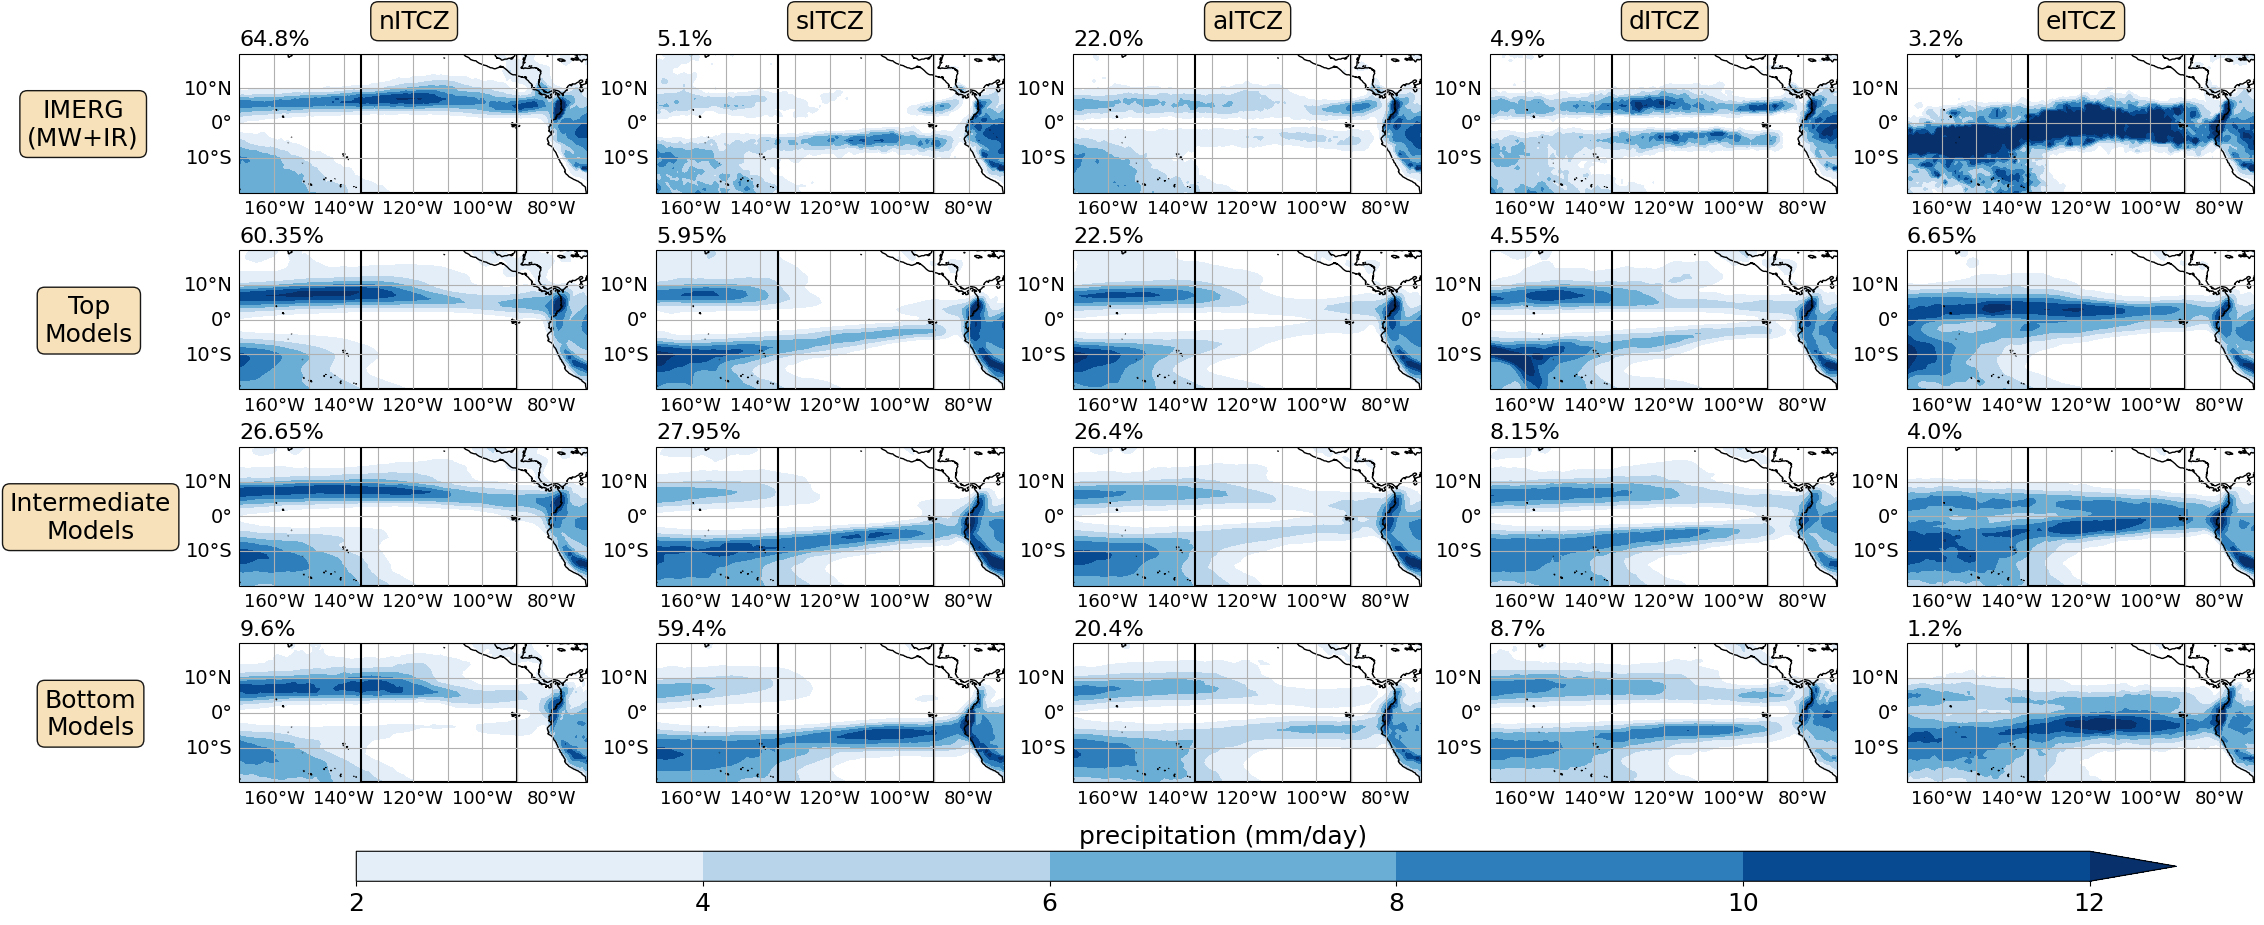

In [55]:
offset = 0
npan = 5
# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(26, 10))#, constrained_layout='true')
cc = 0 
for jj in range(0,4,1):
    for ii in range(0,nitst,1):
        ax1 = fig.add_subplot(5,npan,cc+1,projection=ccrs.PlateCarree())
        ax1.coastlines('50m')
        gl = ax1.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
        gl.xlocator = mticker.FixedLocator(lon_pts)
        gl.ylocator = mticker.FixedLocator([-20, -10, 0, 10, 20])
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 13, 'color': 'k'}
        gl.ylabel_style = {'size': 14, 'color': 'k'}

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
        
        cf = plt.contourf(pr_ITCZ_g1_avg[lon_name], pr_ITCZ_g1_avg[lat_name], pr_ITCZ_all[:,:,ind_final[ii],jj], \
                     cmap=color_map, transform=ccrs.PlateCarree(),levels=levp, extend ='max')
        
        plt.plot(lon_plt_epac,lat_plt_epac,color='k')
        plt.title(str(np.round(prc_ITCZ_all[jj,ind_final[ii]].values,2))+'%', loc='left', fontsize=16)

        if cc == 0:
            # place a text box in upper left in axes coords
            ax1.text(-0.61, 0.68, 'IMERG\n(MW+IR)', transform=ax1.transAxes, fontsize=18,
                verticalalignment='top',multialignment='center',bbox=props)
        elif cc == 5:
            # place a text box in upper left in axes coords
            ax1.text(-0.56, 0.68, 'Top\nModels', transform=ax1.transAxes, fontsize=18,
                verticalalignment='top', multialignment='center', bbox=props)
        elif cc == 10:
            # place a text box in upper left in axes coords
            ax1.text(-0.66, 0.68, 'Intermediate\nModels', transform=ax1.transAxes, fontsize=18,
                verticalalignment='top', multialignment='center', bbox=props)
        elif cc == 15:
            # place a text box in upper left in axes coords
            ax1.text(-0.56, 0.68, 'Bottom\nModels', transform=ax1.transAxes, fontsize=18,
                verticalalignment='top', multialignment='center', bbox=props)
            
        if cc < 5:
            ax1.text(0.4, 1.32, itcz_states[ind_final[cc]], transform=ax1.transAxes, fontsize=18,
                verticalalignment='top', bbox=props)
        cc = cc + 1
        
fig.subplots_adjust(bottom=-0.07)
#cb = plt.colorbar(cf, orientation='horizont09l', pad=0.03)
cbar_ax = fig.add_axes([0.17, 0.04, 0.7, 0.03])
cb = fig.colorbar(cf, cax=cbar_ax, orientation="horizontal")
cb.ax.set_title('precipitation (mm/day)',size=18)
cb.ax.tick_params(labelsize=18) 

plt.savefig(figfolder+figname, dpi=150)